In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
# from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [174]:
### useful functions
def univar_ttest(X: pd.DataFrame, y) -> pd.DataFrame:
    xx = pd.concat([X, y], axis = 1)
    # ratio = []
    # for col in df_clinic.columns:
    #     if col != "Age":
    #         t = xx.groupby("hasPAD")[col].mean()
    #         ratio.append(t[1] / t[0])
    # ratio_series = pd.Series(ratio, index = df_clinic.columns[1:])

    pval = []
    for col in xx.columns[:-1]:
        grp1 = xx.loc[xx.hasPAD == 1, col]
        grp2 = xx.loc[xx.hasPAD == 0, col]
        # print("Protein {} has variance test p-value: {:.2f} ".format(protein, levene(grp1, grp2)[1]))
        pval.append(ttest_ind(grp1, grp2, equal_var=False)[1])

    t_test = pd.DataFrame(pval, index=xx.columns[:-1], columns=["p_value"])
    t_test["ttest_sig"] = (t_test["p_value"] < 0.05).astype(int)
    print(t_test.round(8).sort_values("p_value"))
    return t_test

def correlation_plot(X):
    fig, ax = plt.subplots(figsize=(20, 20))
    corr = X.corr().round(2)
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True, annot_kws={"fontsize":10})
    ax.set_title("Pearson Correlation among proetins", fontsize = 30, pad = 20)
    plt.show()
    # plt.savefig('./reports/hq.png', format='png', dpi=300)

def plot_importance(series: pd.Series):
    f, ax = plt.subplots(figsize=(10, 15))
    sns.set_color_codes("pastel")
    fig = sns.barplot(x = series.values, y = series.index, color="r")
    fig.set_title("Feature Importance", fontsize = 30)
    fig.axvline(x=series.mean(), )
    return fig

In [175]:
df = pd.read_csv("./Data/processed_panel_1and3.csv")

PROTEINS = df.iloc[:,1:df.columns.get_loc("Age")].columns.to_list()
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

TARGET = ["hasPAD"]
df.head()


,ID,IL-33,uPAR,CXCL6,ESM-1,SCF,TSG-14,IL-2,PCSK9,RAGE,...,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc,hasPAD
0,5,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.515919,69268.582453,3231.556933,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0
1,14,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.976533,66247.932316,2459.595380,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0
2,92,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.580556,117311.334839,1455.813626,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,119,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.539790,115404.072833,4621.795653,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
4,124,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.068512,137419.409806,2821.843801,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0


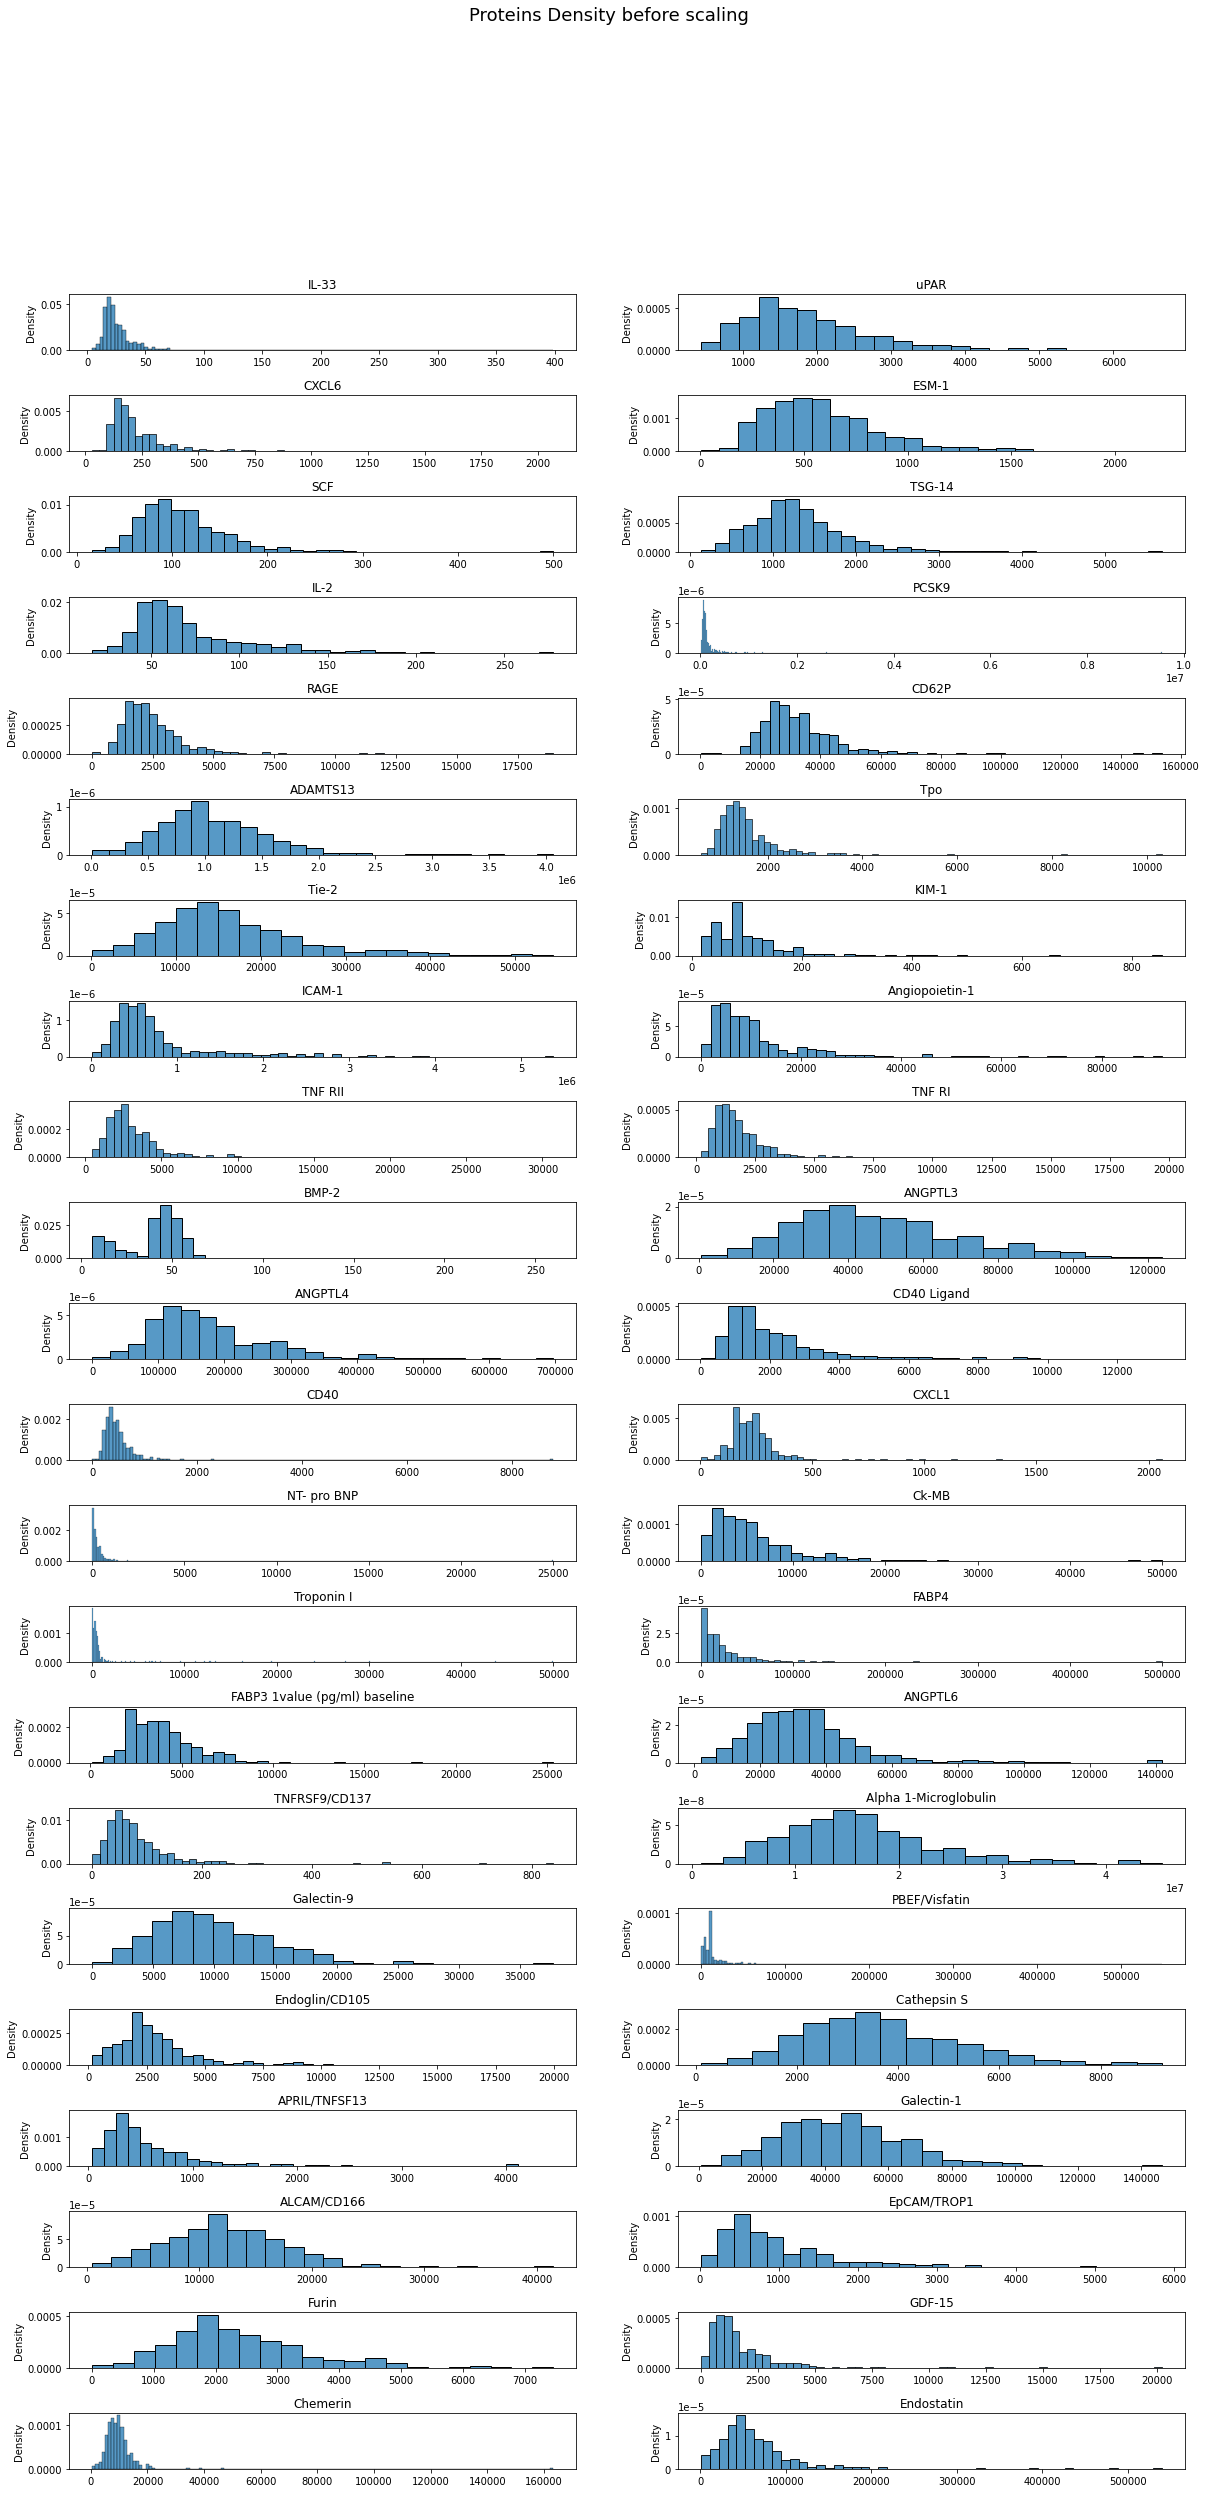

In [176]:
n = len(PROTEINS)
fig, axs = plt.subplots(nrows = n//2, ncols = 2, figsize = (20,40))
plt.subplots_adjust(hspace=.8) #space between subplots
fig.suptitle("Proteins Density before scaling", fontsize=18)


for col, ax in zip(PROTEINS, axs.ravel()):
    g = sns.histplot(df[col], stat='density', ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

In [177]:
df.shape

(461, 65)

In [178]:
[col for col in df.columns if col not in PROTEINS + CLINICAL]

['ID', 'Dialysis', 'oral hypoglyc', 'hasPAD']

In [179]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
# prot_pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="mean")),
#     ('scaler', StandardScaler())
# ])


numeric_features = PROTEINS + ["Age"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = [col for col in CLINICAL if col not in ("Age")]
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numeric_features),
        ("discrete", categorical_transformer, categorical_features),
    ]
)

In [180]:
X = preprocessor.fit_transform(df)
feat_out = [i.split("__")[1] for i in preprocessor.get_feature_names_out(df.columns)]

X = pd.DataFrame(
    X,
    columns= feat_out
)
y = df["hasPAD"]
X.shape

(461, 61)

In [181]:
from sklearn.feature_selection import f_classif, chi2

anova = pd.DataFrame(f_classif(X[numeric_features], y)[1], index = numeric_features, columns=["Anova_p"])
anova["anova_sig"] = (anova.Anova_p < 0.05).astype(int)
num_feat_selected = anova.loc[anova.anova_sig == 1].index
print("Anova test results grouped on continous features: \n", anova.anova_sig.value_counts())
num_feat_selected

Anova test results grouped on continous features: 
 1    26
0    20
Name: anova_sig, dtype: int64


Index(['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age'],
      dtype='object')

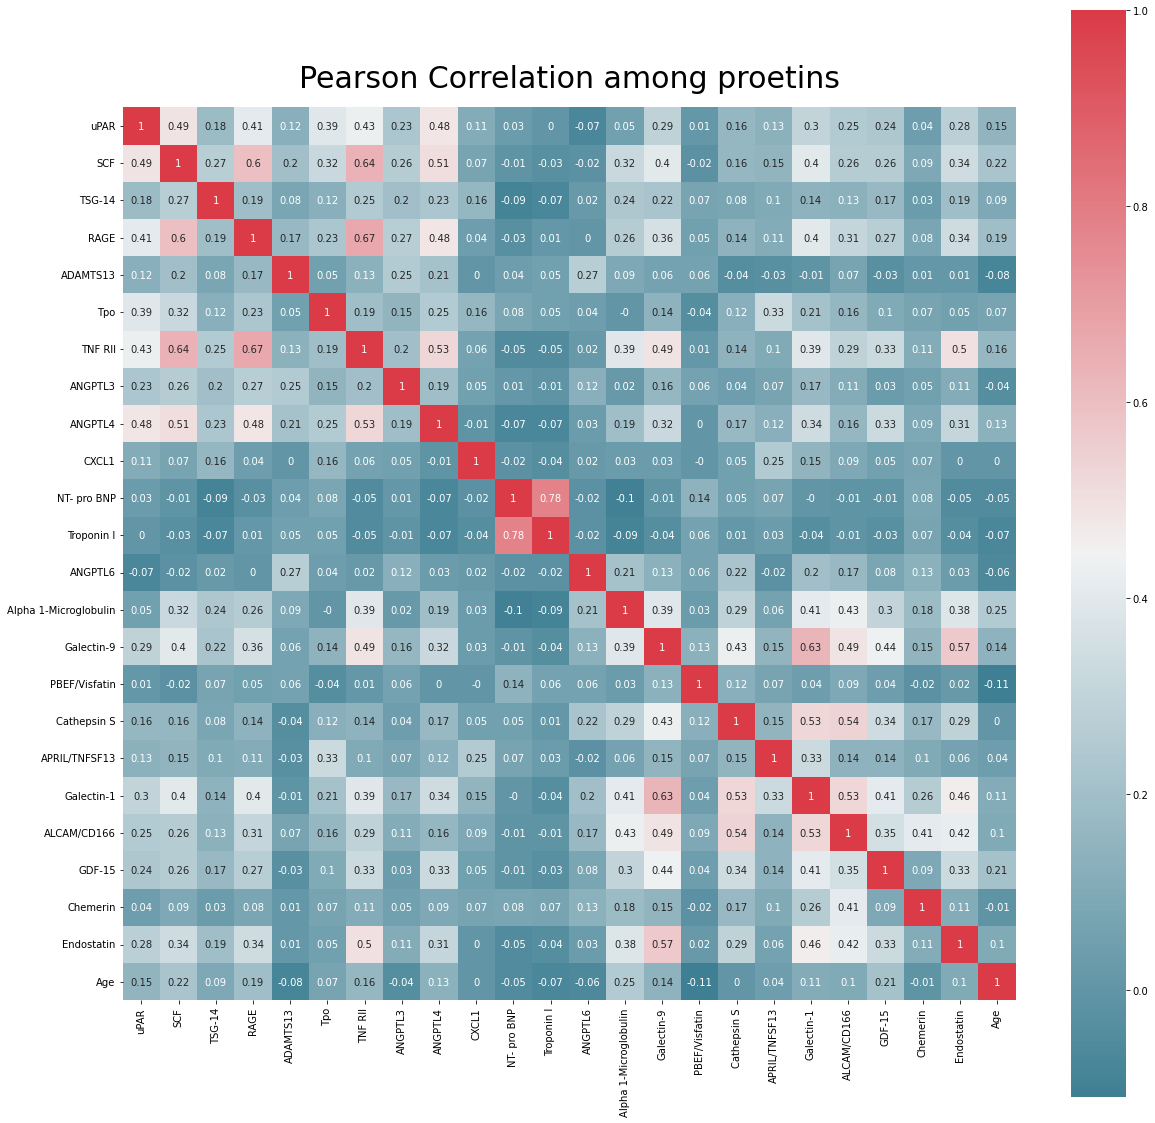

In [182]:
num_feat_selected_dropCor = [x for x in num_feat_selected if x not in ("TNF RI", "CD40")]
correlation_plot(X[num_feat_selected_dropCor])
## Maybe drop SCF,RAGE or TNF RII

# correlation_plot(X[num_feat_selected])

In [183]:
chi2 = pd.DataFrame(chi2(X[categorical_features], y)[1] , index = categorical_features, columns=["chi2_p"])
chi2["chi2_sig"] = (chi2.chi2_p < 0.05).astype(int)
cat_feat_selected = chi2.loc[chi2.chi2_sig == 1].index.tolist()
print("Anova test results grouped on continous features: \n", chi2.chi2_sig.value_counts())
cat_feat_selected

Anova test results grouped on continous features: 
 1    11
0     4
Name: chi2_sig, dtype: int64


['Hypertension',
 'Hyperchol',
 'Diabetes',
 'Renal Insufficiency',
 'Smoking Hx',
 'Congestive heart failure',
 'Cornary artery disease',
 'Stroke/TIA',
 'statin',
 'ACEi/ARB',
 'CCB']

In [184]:
chi2

,chi2_p,chi2_sig
Gender,0.541126,0
Hypertension,0.001248,1
Hyperchol,0.031114,1
Diabetes,0.000017,1
Renal Insufficiency,0.045804,1
Smoking Hx,0.005744,1
Congestive heart failure,0.011459,1
Cornary artery disease,0.001464,1
Stroke/TIA,0.008919,1
statin,0.013172,1


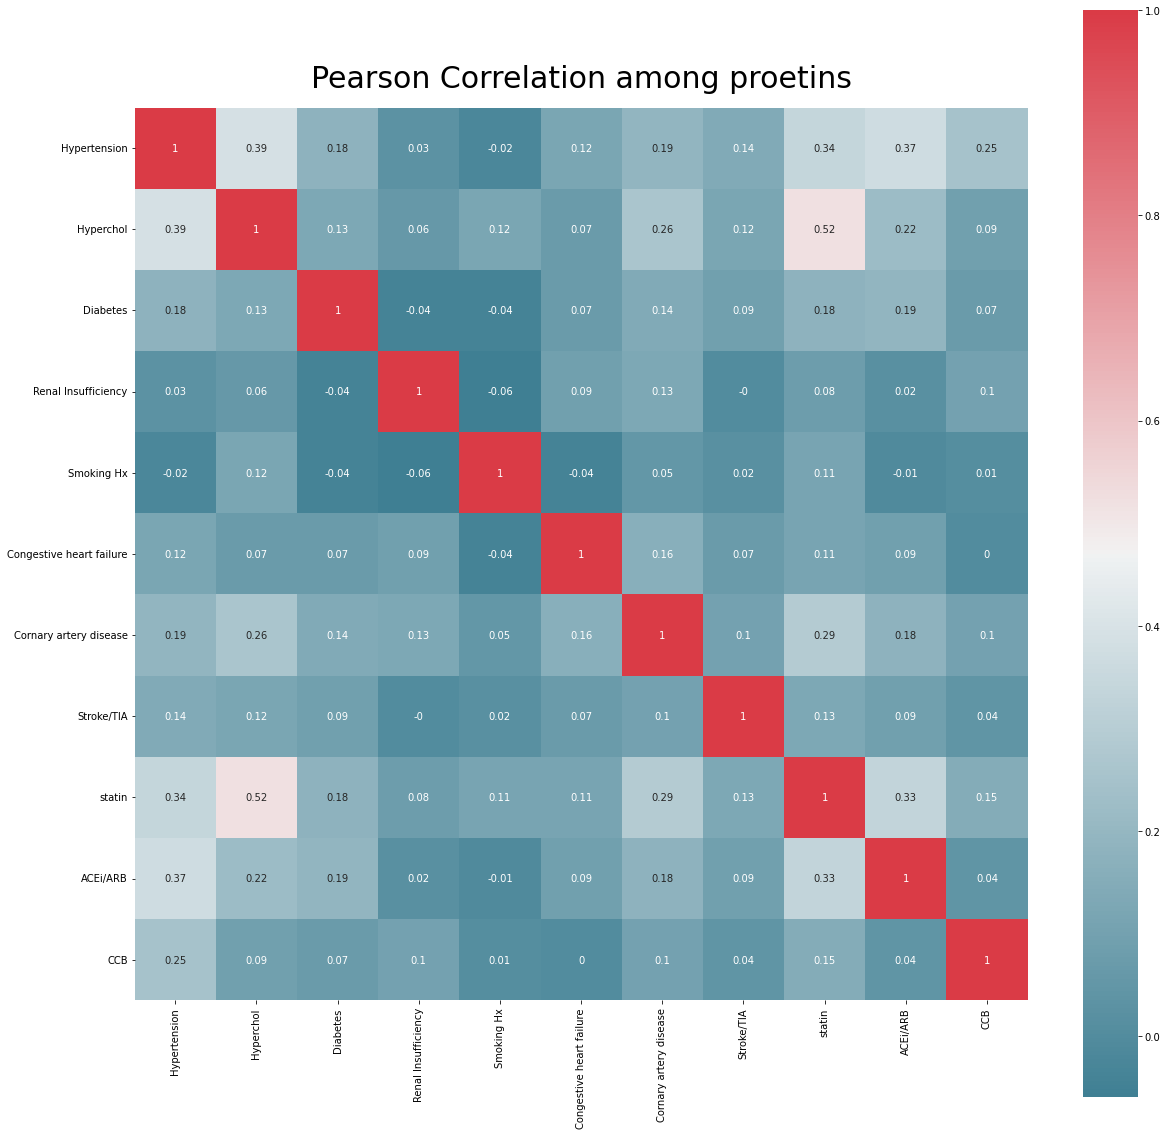

In [185]:
correlation_plot(X[cat_feat_selected])

#no correlation among the selected categoricals

# Builing Models - predict hasPAD

Now that we have narrowed down the feature space nearly by 50%, using simple univariate statistical tests. It's time to do predictive modeling and create the piplines.

In [186]:
newX = df[cat_feat_selected + num_feat_selected_dropCor].copy()
# newX = df[cat_feat_selected ].copy()
# newX = df[num_feat_selected_dropCor].copy()

y = y

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegression(penalty= "l1", solver= 'liblinear',random_state= 42)

#change preprocesseor to not include removed features
preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, num_feat_selected_dropCor),
        ("discrete", categorical_transformer, cat_feat_selected),
    ]
)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

In [187]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['uPAR', 'SCF', 'TSG-14',
                                                   'RAGE', 'ADAMTS13', 'Tpo',
                                                   'TNF RII', 'ANGPTL3',
                                                   'ANGPTL4', 'CXCL1',
                                                   'NT- pro BNP', 'Troponin I',
                                                   'ANGPTL6',
                                                   'Alpha 1-Microglobulin',
                                                   'Galectin-9',
                                                   'PBEF/Visfatin',
                                                   'Cathepsin S...
                                                   'Endostatin', 'Age']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Hypertension', 'Hyperchol',
                                                   'Diabetes',
                                                   'Renal Insufficiency',
                                                   'Smoking Hx',
                                                   'Congestive heart failure',
                                                   'Cornary artery disease',
                                                   'Stroke/TIA', 'statin',
                                                   'ACEi/ARB', 'CCB'])])),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [188]:
# test 
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
print(f"Test AUC Performance on LR = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Train AUC Performance on LR = {metrics.roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:,1]):.3f}")

Test AUC Performance on LR = 0.776
Train AUC Performance on LR = 0.879


* AUC score LR with L1 regularization
    * Clinical and Protein: 0.77 test -- 0.87 train
    * Clinical:             0.75 test -- 0.76 train
    * just proteins:        0.74 test -- 0.85 train

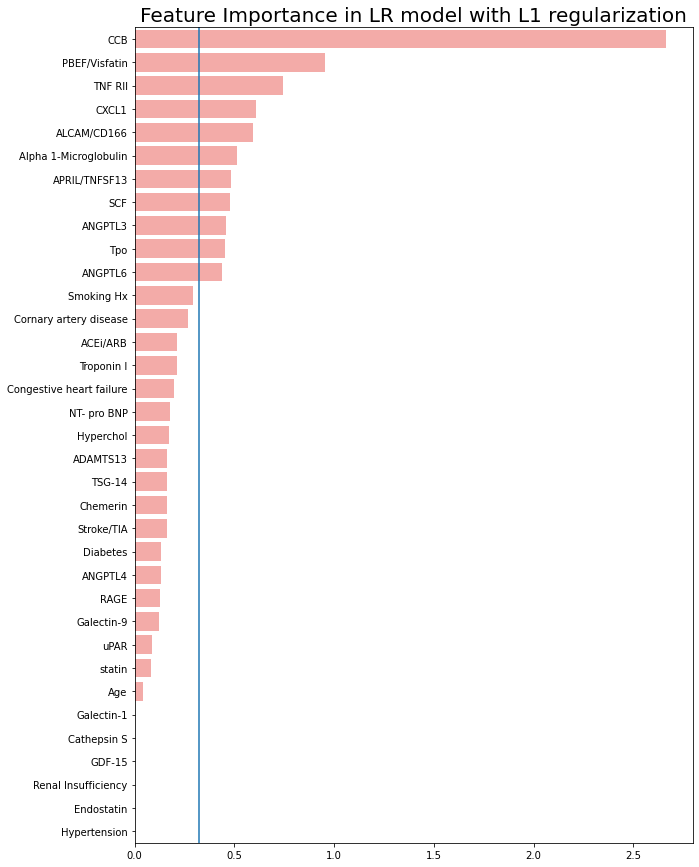

In [189]:
xx = pd.Series(np.abs(model_pipe["classifier"].coef_.squeeze()), index= X_train.columns).sort_values(ascending=False)
top_LR = xx[:15].index
fig = plot_importance(xx)
fig.set_title("Feature Importance in LR model with L1 regularization", fontsize = 20)
plt.show()

## Using Recursive Feature Elminiation

In [18]:
newX = df[cat_feat_selected + num_feat_selected_dropCor].copy()
y = y

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegression(penalty= "l1", solver= 'liblinear',random_state= 42    )

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=myModel,
    step=1,
    cv=StratifiedKFold(5),
    scoring= "roc_auc",
    min_features_to_select=min_features_to_select,
)
#change preprocesseor to not include removed features
preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, num_feat_selected_dropCor),
        ("discrete", categorical_transformer, cat_feat_selected),
    ]
)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('RFE', rfecv),
    ('classifier', myModel)
])

In [19]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['uPAR', 'SCF', 'TSG-14',
                                                   'RAGE', 'ADAMTS13', 'Tpo',
                                                   'TNF RII', 'ANGPTL3',
                                                   'ANGPTL4', 'CXCL1',
                                                   'NT- pro BNP', 'Troponin I',
                                                   'ANGPTL6',
                                                   'Alpha 1-Microglobulin',
                                                   'Galectin-9',
                                                   'PBEF/Visfatin',
                                                   'Cathepsin S...
                                                   'Congestive heart failure',
                                                   'Cornary artery disease',
                                                   'Stroke/TIA', 'statin',
                                                   'ACEi/ARB', 'CCB'])])),
                ('RFE',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=LogisticRegression(penalty='l1',
                                                    random_state=42,
                                                    solver='liblinear'),
                       scoring='roc_auc')),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [20]:
#drops
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.7761797752808988

In [21]:
len(model_pipe["RFE"].get_feature_names_out(X_train.columns))

30

In [22]:
model_pipe["classifier"].n_features_in_

30

In [23]:
###5 features got dropped

In [24]:
model_pipe["classifier"].coef_

array([[-0.17432661,  0.13386308, -0.29432336,  0.19600945,  0.26933179,
        -0.1597951 , -0.08009706,  0.21358   , -2.66416236, -0.0855536 ,
        -0.47559151,  0.16004859, -0.12620948, -0.16432898,  0.45149399,
         0.74193976, -0.4583962 , -0.13120806,  0.61095058,  0.17779584,
         0.21232572,  0.43610685,  0.51031564,  0.12362033,  0.95228571,
         0.48428243,  0.59111362,  0.15895779,  0.        ,  0.0421081 ]])

> The use of RFE with LR is pretty much removing the zero coefs in L1 regularization. The Last plot importance shows the most important features here.

# Random Forest

In [162]:
newX = df[cat_feat_selected + num_feat_selected_dropCor].copy()
y = y

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

mod_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)

# min_features_to_select = 1  # Minimum number of features to consider
# rfecv = RFECV(
#     estimator=mod_rf,
#     step=1,
#     cv=StratifiedKFold(5),
#     scoring= "roc_auc",
#     min_features_to_select=min_features_to_select,
# )
#change preprocesseor to not include removed features
preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, num_feat_selected_dropCor),
        ("discrete", categorical_transformer, cat_feat_selected),
    ]
)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', mod_rf)
])

In [163]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['uPAR', 'SCF', 'TSG-14',
                                                   'RAGE', 'ADAMTS13', 'Tpo',
                                                   'TNF RII', 'ANGPTL3',
                                                   'ANGPTL4', 'CXCL1',
                                                   'NT- pro BNP', 'Troponin I',
                                                   'ANGPTL6',
                                                   'Alpha 1-Microglobulin',
                                                   'Galectin-9',
                                                   'PBEF/Visfatin',
                                                   'Cathepsin S...
                                                   'Galectin-1', 'ALCAM/CD166',
                                                   'GDF-15', 'Chemerin',
                                                   'Endostatin', 'Age']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Hypertension', 'Hyperchol',
                                                   'Diabetes',
                                                   'Renal Insufficiency',
                                                   'Smoking Hx',
                                                   'Congestive heart failure',
                                                   'Cornary artery disease',
                                                   'Stroke/TIA', 'statin',
                                                   'ACEi/ARB', 'CCB'])])),
                ('classifier', RandomForestClassifier())])

In [164]:
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.8706741573033707

In [165]:
##Let's analyze the pipline more
model_pipe["classifier"].n_features_in_

35

In [166]:
model_pipe["classifier"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Hyper parameter tuning

In [167]:
### tune the random forest 

param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 200, 300, 500],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
}

search = GridSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.795):
{'classifier__max_features': 0.5, 'classifier__n_estimators': 100}


In [168]:
mod_rf_tuned = RandomForestClassifier(n_estimators=500, max_features=0.4, max_depth=None, min_samples_split=2, random_state=42)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', mod_rf_tuned)
])
model_pipe.fit(X_train, y_train)

y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.8689887640449439

In [169]:
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
print(f"Test AUC Performance on RF = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Train AUC Performance on RF = {metrics.roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:,1]):.3f}")

Test AUC Performance on RF = 0.869
Train AUC Performance on RF = 1.000


In [56]:
####reaches 0.87 AUC score

# Plot importance and move to XGboost as the next model

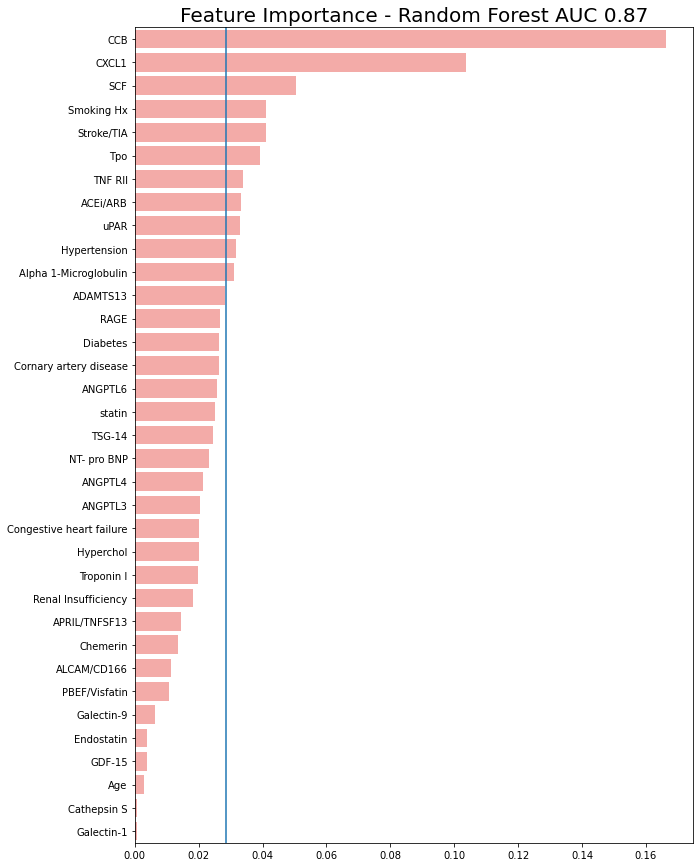

In [171]:
xx = pd.Series(np.abs(model_pipe["classifier"].feature_importances_.squeeze()), index= X_train.columns).sort_values(ascending=False)
##selecting top 15 features
top_RF = xx[:15].index

fig = plot_importance(xx)
fig.set_title("Feature Importance - Random Forest AUC 0.87", fontsize = 20)
plt.show()

`CCB` is the top feature again.

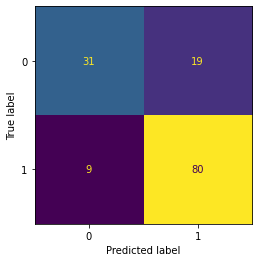

In [172]:
##train accuracy of 100% -- possibly over-fitted

# test conf matrix
metrics.ConfusionMatrixDisplay.from_estimator(model_pipe, X_test, y_test, colorbar=False)
plt.show()

# XGBoost

In [28]:
newX = df[cat_feat_selected + num_feat_selected_dropCor].copy()
y = y

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100, max_depth=None, min_samples_split=2)

# min_features_to_select = 1  # Minimum number of features to consider
# rfecv = RFECV(
#     estimator=clf,
#     step=1,
#     cv=StratifiedKFold(5),
#     scoring= "roc_auc",
#     min_features_to_select=min_features_to_select,
# )
#change preprocesseor to not include removed features
preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, num_feat_selected_dropCor),
        ("discrete", categorical_transformer, cat_feat_selected),
    ]
)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', clf)
])

In [29]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['uPAR', 'SCF', 'TSG-14',
                                                   'RAGE', 'ADAMTS13', 'Tpo',
                                                   'TNF RII', 'ANGPTL3',
                                                   'ANGPTL4', 'CXCL1',
                                                   'NT- pro BNP', 'Troponin I',
                                                   'ANGPTL6',
                                                   'Alpha 1-Microglobulin',
                                                   'Galectin-9',
                                                   'PBEF/Visfatin',
                                                   'Cathepsin S...
                                                   'GDF-15', 'Chemerin',
                                                   'Endostatin', 'Age']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Hypertension', 'Hyperchol',
                                                   'Diabetes',
                                                   'Renal Insufficiency',
                                                   'Smoking Hx',
                                                   'Congestive heart failure',
                                                   'Cornary artery disease',
                                                   'Stroke/TIA', 'statin',
                                                   'ACEi/ARB', 'CCB'])])),
                ('classifier', GradientBoostingClassifier(max_depth=None))])

In [34]:
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
print(f"Test AUC Performance on GBT = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Train AUC Performance on GBT = {metrics.roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:,1]):.3f}")

Test AUC Performance on GBT = 0.672
Train AUC Performance on GBT = 1.000


> It is evident that the model has overfitted to training samples

In [32]:
model_pipe['classifier'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Tuning parameters

In order to achieve maximum performance, GBT models must be fine tuned to achieve it's peak performance

### 1. Tuning boosting parameters

In [134]:
param_grid = {
    # 'loss': ['log_loss', 'exponential'],
    'max_depth': range(3,10),
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.8, 0.9, 1] #stochastic gradient boosting
}
param_grid = {f"classifier__{k}":v for k,v in param_grid.items()}


clf = GradientBoostingClassifier(loss='log_loss', random_state=42 )

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.841):
{'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.05}


In [135]:
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search.cv_results_)
cv_results["mean_test_error"] = cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error", ascending=False).reset_index(drop=True)

,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__learning_rate,param_classifier__subsample,mean_test_error,std_test_error
0,4,200,0.05,0.7,0.840946,0.058180
1,4,200,0.01,0.8,0.840304,0.066672
2,5,50,0.05,0.7,0.837273,0.062352
3,8,500,0.01,0.7,0.836453,0.067001
4,8,50,0.05,0.8,0.836319,0.065677
...,...,...,...,...,...,...
95,9,1,0.5,0.9,0.682648,0.099223
96,8,2,0.05,1,0.635277,0.078916
97,9,1,0.05,1,0.632545,0.042479
98,4,100,2,0.8,0.630849,0.080941


In [136]:
clf = GradientBoostingClassifier(loss='log_loss',
max_depth = 4,
n_estimators=200,
learning_rate=0.05,
subsample = 0.7,
n_iter_no_change= 10,
random_state=42 )

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', clf)
])

model_pipe.fit(X_train, y_train)
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
print(f"Test AUC Performance on GBT = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Train AUC Performance on GBT = {metrics.roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:,1]):.3f}")
print(f"n_estimators with early stopping: {model_pipe['classifier'].n_estimators_}/{model_pipe['classifier'].n_estimators}")

Test AUC Performance on GBT = 0.876
Train AUC Performance on GBT = 0.996
n_estimators with early stopping: 64/200


In [110]:
model_pipe['classifier'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'log_loss',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': 10,
 'random_state': 42,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### 2. Tuning the tree-based parameters


In [139]:
param_grid = {
    'max_features' : [None, 'sqrt', 'log2', 0.3, 0.4, 0.5, 0.6],
    'min_samples_split': [2,4,8,16,32,64],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    
}
param_grid = {f"classifier__{k}":v for k,v in param_grid.items()}

#using clf with tuned boosting parameters

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    # ('RFE', rfecv),
    ('classifier', clf)
])

search = GridSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_jobs=-1, scoring="roc_auc", return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.840):
{'classifier__criterion': 'friedman_mse', 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [140]:
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "std_test_score", 'mean_train_score', 'std_train_score']
cv_results = pd.DataFrame(search.cv_results_)
cv_results[columns].sort_values(by="mean_test_score", ascending=False).reset_index(drop=True)

,param_classifier__max_features,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.5,2,1,friedman_mse,0.840499,0.061082,0.987684,0.011538
1,0.5,8,1,friedman_mse,0.837300,0.063231,0.987943,0.009573
2,0.5,8,2,squared_error,0.836672,0.053442,0.988701,0.009025
3,None,8,2,squared_error,0.836515,0.060018,0.986492,0.006895
4,0.5,8,2,friedman_mse,0.836228,0.055894,0.988558,0.008169
...,...,...,...,...,...,...,...,...
583,0.3,16,100,friedman_mse,0.500000,0.000000,0.500000,0.000000
584,0.3,32,100,friedman_mse,0.500000,0.000000,0.500000,0.000000
585,0.3,64,100,friedman_mse,0.500000,0.000000,0.500000,0.000000
586,0.5,64,100,friedman_mse,0.500000,0.000000,0.500000,0.000000


Below you can see the list of all tuned parameters for GBT:

In [142]:
tuned_pipline = search.best_estimator_
search.best_estimator_['classifier'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'log_loss',
 'max_depth': 4,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': 10,
 'random_state': 42,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### Tree pruning

The Grid searches above show that the training accuracy is too high and this could show an overfitted model. Tree pruning could be helpful in this case.

In [143]:
##tuning the ccp_alpha to prune tree for better generalizablity
### now tuning the tree-based parameters
param_grid = {
    'ccp_alpha': np.linspace(0, 0.01, 50)
}
param_grid = {f"classifier__{k}":v for k,v in param_grid.items()}

#using clf with tuned boosting parameters

search = GridSearchCV(tuned_pipline, param_grid, cv= StratifiedKFold(5), n_jobs=-1, scoring="roc_auc", return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.841):
{'classifier__ccp_alpha': 0.0016326530612244899}


In [144]:
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "std_test_score", 'mean_train_score', 'std_train_score']
cv_results = pd.DataFrame(search.cv_results_)
cv_results[columns].sort_values(by="mean_test_score", ascending=False).reset_index(drop=True)

,param_classifier__ccp_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.001633,0.840881,0.062835,0.986372,0.009858
1,0.000204,0.840639,0.061963,0.987443,0.009483
2,0.0,0.840499,0.061082,0.987684,0.011538
3,0.000612,0.840374,0.063979,0.987171,0.008279
4,0.001224,0.840126,0.061884,0.986677,0.007136
5,0.001837,0.839519,0.063737,0.986662,0.009982
6,0.002041,0.838739,0.062414,0.987033,0.007968
7,0.00102,0.836974,0.070713,0.987720,0.008484
8,0.001429,0.835572,0.062232,0.986804,0.010096
9,0.003673,0.835391,0.057377,0.982153,0.008844


In [150]:
final_tuned_params = search.best_estimator_['classifier'].get_params()

In [151]:
final_tuned_params

{'ccp_alpha': 0.0016326530612244899,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'log_loss',
 'max_depth': 4,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': 10,
 'random_state': 42,
 'subsample': 0.7,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## XGBOOST final results

In [152]:
newX = df[cat_feat_selected + num_feat_selected_dropCor].copy()
y = y

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

clf = GradientBoostingClassifier(**final_tuned_params)

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, num_feat_selected_dropCor),
        ("discrete", categorical_transformer, cat_feat_selected),
    ]
)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])


model_pipe.fit(X_train, y_train)
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
print(f"Test AUC Performance on fine-tuned GBT = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
print(f"Train AUC Performance on fine-tuned GBT = {metrics.roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:,1]):.3f}")
print(f"n_estimators with early stopping: {model_pipe['classifier'].n_estimators_}/{model_pipe['classifier'].n_estimators}")

Test AUC Performance on fine-tuned GBT = 0.864
Train AUC Performance on fine-tuned GBT = 0.991
n_estimators with early stopping: 64/200


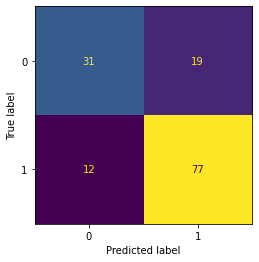

In [157]:
# test conf matrix
metrics.ConfusionMatrixDisplay.from_estimator(model_pipe, X_test, y_test, colorbar=False)
plt.show()

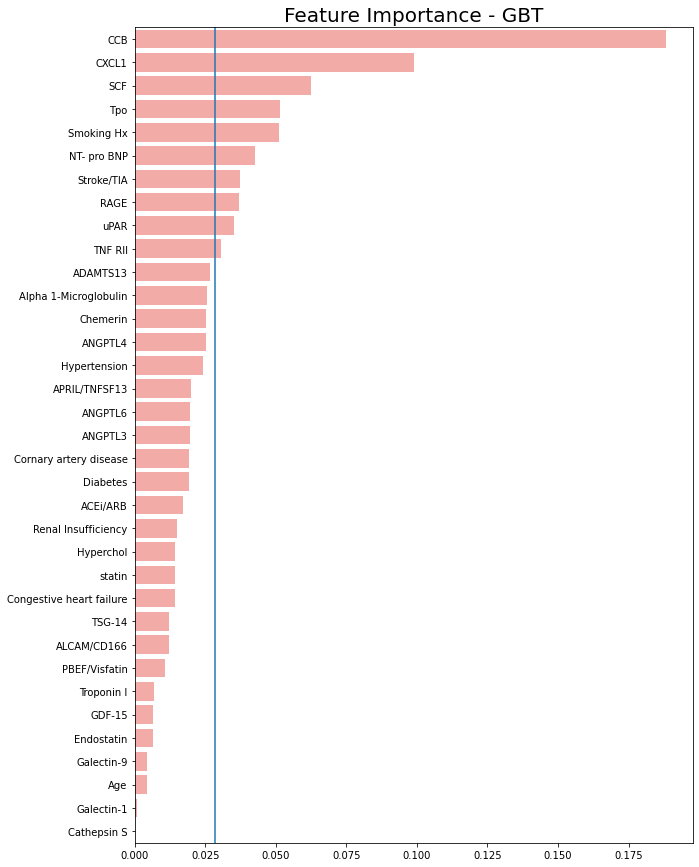

In [160]:
xx = pd.Series(np.abs(model_pipe["classifier"].feature_importances_.squeeze()), index= X_train.columns).sort_values(ascending=False)
top_GBT = xx[:15].index
fig = plot_importance(xx)
fig.set_title("Feature Importance - GBT", fontsize = 20)
plt.show()

# Top Features - 

Combining the results of the top 15 features in the final 3 models, provides the following findings

In [227]:
def highlight(row):
    if row.name in cat_feat_selected:
        return ['background-color: blue'] * len(row)
    else:
        return ['background-color: None'] * len(row)

In [228]:
a = pd.Series(1, index = top_LR).to_frame("Logistic Regression")
b = pd.Series(1, index = top_RF).to_frame("Random Forest")
c = pd.Series(1, index = top_GBT).to_frame("XGBoost")
top_features = a.join(b,how='outer').join(c, how='outer').fillna(0)
top_features["score"] = top_features.sum(axis = 1)
top_features.convert_dtypes().sort_values(by ='score', ascending = False).style.apply(highlight, axis =1)

,Logistic Regression,Random Forest,XGBoost,score
Tpo,1,1,1,3
TNF RII,1,1,1,3
Smoking Hx,1,1,1,3
SCF,1,1,1,3
Alpha 1-Microglobulin,1,1,1,3
CCB,1,1,1,3
CXCL1,1,1,1,3
ACEi/ARB,1,1,0,2
ADAMTS13,0,1,1,2
Stroke/TIA,0,1,1,2


> The rows in BLUE show the clinical features, the rest are Proteins

* TPO, TNF RII, SCF, Alpha 1-Microglobulin, CXCL1 are the MOST IMPORTANT PROTEINS across all predictive models
* ADAMTS13, RAGE, uPAR are the second-tier proteins, being in the top across 2/3 preditive models
*  NT- pro BNP, PBEF/Visfatin, Chemerin, APRIL/TNFSF13, ANGPTL6, ANGPTL4, ANGPTL3, ALCAM/CD166, Troponin I are the top proteins in only 1/3 models

Clinical features such as `smoking` and `CCB` are also most important in detection of PAD